In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')

#sys.path.append( '/home/cactuskid13/miniconda3/pkgs/')
print(sys.path)

['/scratch/dmoi/projects/HogProf/pyprofiler/notebooks', '/scratch/dmoi/condaenvs/ML2/lib/python39.zip', '/scratch/dmoi/condaenvs/ML2/lib/python3.9', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/lib-dynload', '', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages', '/scratch/dmoi/software/pyham', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/IPython/extensions', '/users/dmoi/.ipython', '../..']


In [157]:
#using the profiler. It's easy!
#lets import the profiler, configuration file and some tools for GO analysis to look at our returned results
from pyprofiler.utils import hashutils
import ete3
import random
from pyprofiler.utils import config_utils
import pyprofiler.utils.goatools_utils as goa
import pyprofiler.utils.hashutils as hashutils
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pyprofiler.profiler as profiler
import pandas as pd
import itertools
import redis
##to get the mapping of oma hogs to cogs to interactions in specific species I used dask distributed and a redis server
#you may need to get these up and running for you own cluster configuration before this notebook will work for you

import dask
import scipy
from dask import dataframe as dd
import pickle
from bloom_filter2 import BloomFilter
from sklearn.model_selection import train_test_split


In [3]:
#lets load a compiled db containing the OMA root HOGs into a profiler oject 
p = profiler.Profiler(lshforestpath = '/scratch/dmoi/datasets/all/newlshforest.pkl' , hashes_h5='/scratch/dmoi/datasets/birds/all/hashes.h5' , mat_path= None, oma = '/scratch/dmoi/datasets/OMA/apr2021/OmaServer.h5', tar= None , nsamples = 256 , mastertree = '/scratch/dmoi/datasets/birds/all_test_master_tree.pkl')

loading lsh
indexing lsh


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/tables/leaf.py:367: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


3508
DONE


In [4]:
def grabHog(ID, verbose = True):
    try:
        entry = p.db_obj.entry_by_entry_nr(p.db_obj.id_resolver.resolve(ID))
        return entry[4].decode() , entry
    except:
        return np.nan,np.nan
#map to OMA HOGs

In [5]:
#load humap data
humap = '/scratch/dmoi/datasets/humap_PPI/humap2_ppis_ACC_20200821.pairsWprob'
humap_df = pd.read_table(humap, header = None)
print(humap_df)

                  0                1             2
0            P46926           Q8TDQ7  1.000000e+00
1            P43631           Q14954  1.000000e+00
2            P43631           Q14953  1.000000e+00
3            P43631           P43629  1.000000e+00
4         100287045           Q86YD7  1.000000e+00
...             ...              ...           ...
17526306     Q9H6Z4           Q7L1Q6  3.000000e-14
17526307     Q9Y265           P54578  3.000000e-14
17526308     P16152           P04406  3.000000e-14
17526309     Q96AE4           P78417  3.000000e-14
17526310     P20042  ENSG00000180574  3.000000e-14

[17526311 rows x 3 columns]


In [6]:
#filter to 90%proba
humap_df = humap_df[humap_df[2] > .75 ]
print(len(humap_df))
mapper = set( list(humap_df[1]) + list(humap_df[0]) )
mapper = { protid: grabHog(protid) for protid in mapper }
humap_df['hog1'] = humap_df[1].map(mapper)
humap_df['hog2'] = humap_df[0].map(mapper)

8981


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/tables/leaf.py:367: PerformanceWarning: The Leaf ``/_i_XRef/XRefId/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


In [7]:
humap_df['hogid_1'] = humap_df['hog1'].map(lambda x:x[0])
humap_df['hogid_2'] = humap_df['hog2'].map(lambda x:x[0])
humap_df = humap_df.dropna()
print(len(humap_df))

8576


In [8]:
humap_df['fam1'] = humap_df['hog1'].map( lambda x :   p.hogid2fam(x[1]) )
humap_df['fam2'] = humap_df['hog2'].map( lambda x :   p.hogid2fam(x[1]) ) 
humap_df = humap_df.dropna()
humap_df.fam1 = humap_df.fam1.map(int)
humap_df.fam2 = humap_df.fam2.map(int)
print(len(humap_df))

8360


In [9]:
humap_df.to_csv(humap+'hogmapped.csv')

In [10]:
humap_pairs = humap_df

In [11]:
allhogs = set([])
allhogs = allhogs.union( set(humap_df.fam1.unique() ) )
allhogs = allhogs.union( set(humap_df.fam2.unique() ) )
print(len(allhogs))

3168


In [12]:
profiles = {}
calc_hogs_humap = False
if calc_hogs_humap == True:
    for fam in allhogs:
        print(fam)
        try:
            prof = p.return_profile_OTF(fam)
        except:
            print('err', fam)
        print(prof)
        profiles.update(prof)

In [13]:
import pickle
save_Hogs_humap = False
if save_Hogs_humap == True:
    with open(humap + 'gold_standard_profiles.pkl' , 'wb') as profiles_out:
        profiles_out.write(pickle.dumps(profiles))

In [14]:
import pickle
with open(humap + 'gold_standard_profiles.pkl' , 'rb') as profiles_out:
    humap_profiles = pickle.loads(profiles_out.read())

In [15]:
humap_df = pd.DataFrame.from_dict(humap_profiles , orient = 'index')
print(humap_df.head())

                                                      mat  \
524288  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
516097  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
516099  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
786438  [[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0,...   
573452  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                     tree  
524288  (((\n--7757)), ((\n--7764)), ((\n--9597)), ((\...  
516097  (((\n--9597)), ((\n--9598)), ((\n--9606)), ((\...  
516099  (((\n--9597)), ((\n--9598)), ((\n--9606)), ((\...  
786438  (((\n--868595)), ((\n--349161)), ((\n--696281)...  
573452  (((\n--120017)), ((\n--237631)), ((\n--1230383...  


In [16]:

coglink_df = dd.read_csv('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt', blocksize=25e6 , header = 0, sep = ' ')

In [17]:
print(coglink_df)
print(coglink_df.columns)

Dask DataFrame Structure:
                 group1  group2 neighborhood fusion cooccurence coexpression experimental database textmining combined_score
npartitions=195                                                                                                             
                 object  object        int64  int64       int64        int64        int64    int64      int64          int64
                    ...     ...          ...    ...         ...          ...          ...      ...        ...            ...
...                 ...     ...          ...    ...         ...          ...          ...      ...        ...            ...
                    ...     ...          ...    ...         ...          ...          ...      ...        ...            ...
                    ...     ...          ...    ...         ...          ...          ...      ...        ...            ...
Dask Name: read-csv, 195 tasks
Index(['group1', 'group2', 'neighborhood', 'fusion', 'cooccurence',


In [18]:
dropcols = ['neighborhood', 'fusion', 'cooccurence', 'combined_score' ]
coglink_df = coglink_df.drop(columns = dropcols)
coglink_df['score'] = coglink_df.coexpression + coglink_df.experimental +coglink_df.database+ coglink_df.textmining

In [19]:
coglink_df= coglink_df[coglink_df.score>1000]
print(len(coglink_df))
coglink_df = coglink_df.compute()

500428


In [20]:
print(coglink_df.head())

      group1   group2  coexpression  experimental  database  textmining  score
0    COG0001  COG0002            79             0       741         361   1181
4    COG0001  COG0007           105           424         0         529   1058
76   COG0001  COG0113           355             0       741         822   1918
130  COG0001  COG0181           213             0       741         822   1776
305  COG0001  COG0549             0             0       741         263   1004


In [21]:
grabcogs = set( list(coglink_df.group1.unique()) + list(coglink_df.group2.unique()) )

In [22]:
grabcogs= list(grabcogs)

In [23]:
print(len(grabcogs), grabcogs[0:100])

13067 ['NOG05525', 'NOG07083', 'NOG49459', 'COG0530', 'NOG259259', 'COG5498', 'NOG21495', 'NOG233604', 'KOG2122', 'NOG20741', 'COG0161', 'NOG29147', 'NOG13900', 'COG1798', 'COG3522', 'COG1825', 'COG0116', 'NOG33296', 'NOG05051', 'COG0136', 'COG1260', 'COG1272', 'NOG07369', 'NOG258865', 'NOG91697', 'NOG36849', 'COG1400', 'KOG1042', 'KOG2501', 'NOG244415', 'NOG248591', 'NOG96140', 'COG0310', 'NOG238447', 'COG0308', 'NOG78272', 'COG1734', 'COG1027', 'COG5026', 'COG5563', 'NOG10705', 'NOG08472', 'NOG98530', 'NOG95764', 'NOG254095', 'KOG4034', 'NOG270884', 'NOG273358', 'COG1566', 'NOG269599', 'COG0718', 'NOG274454', 'NOG230231', 'NOG01079', 'KOG4833', 'COG1286', 'COG1912', 'NOG01446', 'KOG2242', 'KOG3770', 'NOG73461', 'NOG87680', 'NOG07806', 'NOG35762', 'NOG86122', 'KOG3856', 'NOG15496', 'COG2123', 'NOG05625', 'NOG257558', 'KOG4790', 'NOG71599', 'NOG02609', 'NOG10824', 'NOG86268', 'COG0699', 'COG0503', 'NOG231436', 'COG3230', 'COG3082', 'NOG234937', 'NOG02509', 'NOG255019', 'NOG23942', 'COG

In [24]:
#map the interacting cogs to the proteins
COGmapings_df = dd.read_csv('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt', blocksize=25e6 , header = 0, sep = '\t')
COGmapings_df = COGmapings_df.set_index('orthologous_group')
COGmapings_df.astype(str)
COGmapings_df['##protein'].map( lambda x : x.strip() )
COGmapings_df['species'] = COGmapings_df['##protein'].map( lambda x : x.split('.')[0] )

COGmapings_df['COG'] = COGmapings_df.index
COGmapings_df = COGmapings_df.loc[grabcogs]

print(COGmapings_df.head())
COGmapings_df = COGmapings_df.compute()

                                       ##protein  start_position  \
orthologous_group                                                  
COG0003            1116232.AHBF01000005_gene1599               1   
COG0003            1116232.AHBF01000010_gene1374               1   
COG0003            1116232.AHBF01000010_gene1375               1   
COG0003                  1077974.GOEFS_081_00530               1   
COG0003                        1078020.KEK_06232               1   

                   end_position                     protein_annotation  \
orthologous_group                                                        
COG0003                     380               annotation not available   
COG0003                     486               annotation not available   
COG0003                     325               annotation not available   
COG0003                     383               annotation not available   
COG0003                     392  COG0003 Oxyanion-translocating ATPase   

    

In [25]:
#only take the proteins in our cogs of interest
compute_grabcogs = False
if compute_grabcogs == True:
    grabprots =list(COGmapings_df['##protein'].unique())
    print(len(grabprots))
    with open('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt' + '.grabcogs.txt', 'w') as protsout:
        protsout.write(''.join([ p + '\n' for p in grabcogs ]) )
    with open('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt' + '.grabprots.txt' , 'w') as protsout:
        protsout.write(''.join([ p + '\n' for p in grabprots ]) )
else:
    with open('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt' + '.grabcogs.txt', 'r') as protsout:
        grabcogs = [ cog for cog in protsout.readlines()]
    with open('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt' + '.grabprots.txt' , 'r') as protsout:
        grabprots = [ prot for prot in protsout.readlines()]


In [26]:
save_protlist = False
if save_protlist == True:
    print('establishng bloom filter for the proteins we want to keep from cogs of interest')
    #establish a filter for the prots
    protlist =  BloomFilter(max_elements=10**8, error_rate=0.001 ,start_fresh = True)
    #df['pair']= df.protein1.astype(str) + '_' + df.protein2.astype(str)
    for i,prot in enumerate(grabprots):
        if i % 100000 == 0:
            print(i/len(grabprots))
        protlist.add(prot.strip())
    print(protlist)
    with open('protbloom.pkl' , 'wb' ) as bloomout:
        bloomout.write(pickle.dumps(protlist))
    print('done')
else:
    with open('protbloom.pkl' , 'rb' ) as bloomout:
        protlist = pickle.loads(bloomout.read())
    print(protlist)
    

BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757)


In [27]:
print(grabprots[0].strip() ,grabprots[0].strip() in protlist )
print('crap','crap' in protlist)

1000565.METUNv1_01990 True
crap False


In [28]:
#establish cog2hog mapping
print(len(grabprots))

17064691


In [29]:
calc_mappers = False
rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
if calc_mappers == True:
    count = 0 
    for i,r in COGmapings_df.iterrows():
        rdb.set(r['##protein'], i)
        count+=1
        if count < 10:
            print(i+'\n',r)
        if count%1000000==0:
            print(count/len(COGmapings_df))
    #protmapper[r['##protein']] = i    
    #protmapper = dict( zip(COGmapings_df['##protein'] , COGmapings_df.index ) )
    #cogexample = dict( zip( COGmapings_df.index ,  COGmapings_df['##protein']   ) )
    
    #with open('cogmappers.pkl' , 'wb')as cogmappers_out:
    #    cogmappers_out.write(pickle.dumps((protmapper, cogexample)) )
#else:
#    with open('cogmappers.pkl' , 'rb')as cogmappers_out:
#        protmapper, cogexample = pickle.loads(cogmappers_out.read())

In [30]:
#print(len(grabcogs))
print(len(COGmapings_df))

17681656


In [31]:
maphogs = False
if maphogs == True:
    rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
    hogmap = {}
    for i,prot in enumerate(grabprots):
        if i % 100000 == 0 :
            print(i/len(grabprots))
        cog = rdb.get(prot)
        if cog not in hogmap:
            mapped =  grabHog(prot)
            #retry until something maps
            if mapped[0] != np.nan and type(mapped[0]) == str :
                if len(mapped[0])>1 :
                    hogmap[cog] = mapped
    with open('stringhogmap.pkl' , 'wb')as hogmapout:
        hogmapout.write(pickle.dumps(hogmap))
else:
    with open('stringhogmap.pkl' , 'rb')as hogmapout:
        hogmap = pickle.loads(hogmapout.read())


In [32]:
print(len(hogmap))
for i, key in enumerate(hogmap):
    if i < 10:
        print(key, hogmap[key])

12761
b'COG0022' ('HOG:A0772469', (1134780, 359776777, 338, 36877, b'HOG:A0772469', b'A', 136963, 137976, -1, 0, b'Q9K3H1', 1080465110, 1015, b'6161cbb7b6aed10547b7c95555c1c63a', 60128051, 322, b'', -1, -1))
b'COG1071' ('HOG:A0780700.10b.7b', (3753108, 1179251817, 734, 598427, b'HOG:A0780700.10b.7b', b'A', 2952449, 2954650, -1, 0, b'F4GWD5', 3541508558, 2203, b'0eaa8538e27a234812d4b19c67f1f560', 234217123, 43, b'', -1, -1))
b'COG0508' ('HOG:A0757171.22b.54b.29a', (3288989, 1034223672, 469, 598421, b'HOG:A0757171.22b.54b.29a', b'A', 1363913, 1365319, 1, 0, b'G4R8Y9', 3105960004, 1408, b'3b9ecc15f5881cc16928ba7e6a656fe6', 205095449, 48, b'', -1, -1))
b'COG0462' ('HOG:A0780700', (14151364, 5935651032, 846, 598427, b'HOG:A0780700', b'supercontig_To_g48347', 2246, 4990, -1, 0, b'K0RIS8', 17821104459, 2539, b'8f2ac7bfb36b9ffe82ad5d8dc2410bae', 696068665, 22, b'', -1, -1))
b'COG4886' ('HOG:A0779810.2c.30a.12a.2a', (16107232, 6695185680, 411, 598444, b'HOG:A0779810.2c.30a.12a.2a', b'1', 160094

In [33]:
#add the HOGs to the COGdf
#grab the corresponding profiles
print(len(coglink_df))
try:
    coglink_df.group1  = coglink_df.group1.map( lambda x : x.encode())
    coglink_df.group2  = coglink_df.group2.map( lambda x : x.encode())
except:
    pass

coglink_df['hog1'] = coglink_df.group1.map(hogmap)
coglink_df['hog2'] = coglink_df.group2.map(hogmap)
coglink_df=coglink_df.dropna()
print(len(coglink_df))
print(coglink_df.head())

500428
495684
         group1      group2  coexpression  experimental  database  textmining  \
0    b'COG0001'  b'COG0002'            79             0       741         361   
4    b'COG0001'  b'COG0007'           105           424         0         529   
76   b'COG0001'  b'COG0113'           355             0       741         822   
130  b'COG0001'  b'COG0181'           213             0       741         822   
305  b'COG0001'  b'COG0549'             0             0       741         263   

     score                                               hog1  \
0     1181  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   
4     1058  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   
76    1918  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   
130   1776  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   
305   1004  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   

                                                  hog2  
0    (HOG:A0780127.8b, [1141676, 362003752, 343, 10

In [34]:
coglink_df['hogid_1'] = coglink_df['hog1'].map(lambda x:x[0])
coglink_df['hogid_2'] = coglink_df['hog2'].map(lambda x:x[0])

In [35]:
coglink_df['fam1'] = coglink_df['hog1'].map( lambda x :   p.hogid2fam(x[1]) )
coglink_df['fam2'] = coglink_df['hog2'].map( lambda x :   p.hogid2fam(x[1]) ) 

coglink_df.fam1 = coglink_df.fam1.map(int)
coglink_df.fam2 = coglink_df.fam2.map(int)


In [36]:
print(coglink_df)

               group1       group2  coexpression  experimental  database  \
0          b'COG0001'   b'COG0002'            79             0       741   
4          b'COG0001'   b'COG0007'           105           424         0   
76         b'COG0001'   b'COG0113'           355             0       741   
130        b'COG0001'   b'COG0181'           213             0       741   
305        b'COG0001'   b'COG0549'             0             0       741   
...               ...          ...           ...           ...       ...   
530407  b'arCOG09486'  b'NOG24221'           263             0       899   
530662  b'arCOG09486'  b'NOG49907'            65             0         0   
530951  b'arCOG09486'   b'COG3338'           568             0         0   
531432  b'arCOG09486'  b'NOG24221'           263             0       899   
531687  b'arCOG09486'  b'NOG49907'            65             0         0   

        textmining  score                                               hog1  \
0      

In [37]:
stringHOGs = set(coglink_df.fam1.unique()).union(set(coglink_df.fam2.unique()))

In [38]:
print(len(stringHOGs))

11890


In [39]:
#coglink_df.to_csv('STRINGCOGS2OMAHOGS.csv')
stringPairs = coglink_df

In [40]:
#derive explicit profiles for our hogs of interest in string
calc_hogs_string = False
stringprofiles = {}
if calc_hogs_string == True:
    print('profiles to calclulate',len(stringHOGs))
    for i,fam in enumerate(stringHOGs):
        if i % 100 ==0:
            print(i)
        try:
            prof = p.return_profile_OTF(fam)
            stringprofiles.update(prof)
        except:
            print('err',fam)

In [41]:
if calc_hogs_string == True:
    with open('/scratch/dmoi/datasets/STRING/' + 'gold_standard_profiles.pkl' , 'wb') as profiles_out:
        profiles_out.write(pickle.dumps(stringprofiles))

In [42]:
with open('/scratch/dmoi/datasets/STRING/' + 'gold_standard_profiles.pkl' , 'rb' )as profiles_out:
    stringprofiles = pickle.loads(profiles_out.read())

In [43]:
string_df = pd.DataFrame.from_dict(stringprofiles , orient='index')

In [44]:
#make the profiles for this small set of HOGs
for i, key in enumerate(stringprofiles):
    if i < 10:
        print(key,stringprofiles[key])

786432 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7ff4d2adb46)}
786433 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7ff4d2f0db5)}
524294 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7ff4d43ec07)}
786440 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7ff4d44d3f1)}
524299 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7ff4d219d6d)}
786448 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7ff4d2141f7)}
786449 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7ff4d1e61bb)}
786450 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7ff4d1b017f)}
131092 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '1648030' (0x7ff4d182043)}
524309 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7ff4d182055)}


In [45]:
#now we have profiles for all HUMAP and COG interactions
#String has interactions from each COG in different species.
#We need a way to check for the presence of interaction within a species for a COG
#for this we will create a bloom filter with all the interactions between our cogs

calc_filter = False

In [46]:
if calc_filter == True:
    from dask.distributed import fire_and_forget
    from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
    from dask_jobqueue import SLURMCluster
    from dask.distributed import  utils_perf
    from dask.distributed import Client, LocalCluster
    import dask
    import redis
    from bloom_filter2 import BloomFilter
    import lzma
    from dask import dataframe as dd
    distributed = True

In [47]:
if calc_filter == True:
    if distributed == True:
        NCORE = 5
        print('deploying cluster')
        cluster = SLURMCluster(
            walltime='4:00:00',
            n_workers = NCORE,
            cores=NCORE,
            processes = NCORE,
            interface='ib0',
            memory="80GB",
            env_extra=[
            'source /scratch/dmoi/miniconda/etc/profile.d/conda.sh',
            'conda activate ML2'
            ],
            scheduler_options={'interface': 'ens2f0' },
            #extra=["--lifetime", "3h55m", "--lifetime-stagger", "4m"]
        )
        print(cluster.job_script())

    else:
        cluster = LocalCluster()
        client = Client(cluster)

In [48]:
if calc_filter == True:
    if distributed == True:
        print(cluster)
        cluster.scale(jobs = 100)
        print(cluster.dashboard_link)
        client = Client(cluster , timeout='450s' , set_as_default=True )

In [49]:
#find which species each of the cogs has an interaction in
if calc_filter == True:
    link_df = dd.read_csv('/scratch/dmoi/datasets/STRING/protein.physical.links.detailed.v11.5.txt', blocksize=100e6 , header = 0, sep = ' ')
    print(link_df)

In [50]:
#compute bloom filters for protein pairs
@dask.delayed
def mapcogs(df ):
    rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
    if type( df ) == tuple:
        df = df[0]
    protlist1 = list(df.protein1.map(lambda x:str(x).strip()))
    protlist2 = list(df.protein2.map(lambda x:str(x).strip()))
    protlist = list(set(protlist1+protlist2))
    data = rdb.mget(protlist)
    mapper = dict(zip(protlist, data) )
    df['COG1'] = df.protein1.map(mapper)
    df['COG2'] = df.protein2.map(mapper)
    df = df.dropna()
    df['COG1'] = df.COG1.map(lambda x:str(x).replace("b",'').replace("'",'').strip() )
    df['COG2'] = df.COG2.map(lambda x:str(x).replace("b",'').replace("'",'').strip() )
    df['species'] = df.protein1.map(lambda x:x.split('.')[0])
    df['coglinks'] = df.COG1 + '_' + df.COG2 + '_' + df.species
    return  list(df.coglinks.unique())

@dask.delayed
def return_filter(coglinks, verbose = True):
    if type( coglinks ) == tuple:
        coglinks = coglinks[0]
    #prots can only interact in one species...
    b=BloomFilter(max_elements=10**8, error_rate=0.001 ,start_fresh = True)
    for p in coglinks:
        b.add( p )
    #b.close()
    #b = lzma.compress( pickle.dumps(b) )
    return   b , len(coglinks)

@dask.delayed
def sumfilter(f1,f2, total ):
    if type( f1 ) == tuple:
        f1 = f1[0]
    if type( f2 ) == tuple:
        f2 = f2[0]
    #f1 = pickle.loads(lzma.decompress( f1) )
    #f2 = pickle.loads(lzma.decompress( f2 ) )
    f3 = f1.__ior__(f2)
    #f3 = lzma.compress( pickle.dumps(f3) )
    return f3 , total

In [51]:
if calc_filter == True:
    partitions  = link_df.to_delayed()
    #print('reduce partitions')
    #res = [ reduce(p,remote_list) for p in partitions ] 
    #print('done')
    print('map cogs')
    res1 = [ mapcogs(p) for p in partitions ] 
    print('done')
    print('make filters')
    res2 = [ return_filter(p) for p in res1 ] 

    totalfilter = res2
    print(len(totalfilter))
    while len(totalfilter)>1:
        next_round= []

        for i in range(0,len(totalfilter),2):
            if i+1 < len(totalfilter):
                next_round.append( sumfilter( totalfilter[i][0] , totalfilter[i+1][0] , totalfilter[i][1]+totalfilter[i+1][1]  ) )

        if len(totalfilter) % 2 !=0:
            next_round.append(totalfilter[-1])
        totalfilter = next_round
        print(len(totalfilter))

    #resfinal = dask.compute(totalfilter)

    print('done')

In [52]:
if calc_filter == True:
    resfinal = dask.compute(totalfilter)

In [53]:
#client.cancel(resfinal)

In [54]:
if calc_filter == True:
    with open('bloomfinal.pkl' , 'wb' ) as finalout:
        finalout.write(pickle.dumps(resfinal))

In [55]:
with open('bloomfinal.pkl' , 'rb' ) as finalout:
    resfinal = pickle.loads(finalout.read()) 
cogfilter =  resfinal[0][0][0]

In [56]:
print('COG1756_COG0088_4113' in cogfilter )

True


In [57]:
#lets try it out. we should be able to find in which species two cogs interact with the bloom filter
cog1='COG0088'
cog2 ='COG1756'
coglink = cog1 + '_' + cog2 + '_'

In [58]:
#test out to find the species for a cog pair
coglinks_species = [ coglink+spec.name  for spec in p.tree.get_leaves()]
species = [ spec.name  for spec in p.tree.get_leaves()]
checklinks = [ coglink+spec in cogfilter for spec in coglinks_species ]

species_set = [s for s in species]
links = [ l for l,c in list(zip(coglinks_species,checklinks))  if c== True  ]
species_set = [ s for s,c in list(zip(species_set,checklinks))  if c== True  ]

print(links)
print(species_set)

['COG0088_COG1756_768706', 'COG0088_COG1756_282458', 'COG0088_COG1756_367830', 'COG0088_COG1756_655816', 'COG0088_COG1756_481743', 'COG0088_COG1756_370552', 'COG0088_COG1756_891391', 'COG0088_COG1756_479436', 'COG0088_COG1756_443150', 'COG0088_COG1756_1768', 'COG0088_COG1756_1790', 'COG0088_COG1756_504474', 'COG0088_COG1756_1032480', 'COG0088_COG1756_1214101', 'COG0088_COG1756_2064', 'COG0088_COG1756_471855', 'COG0088_COG1756_292563', 'COG0088_COG1756_502801', 'COG0088_COG1756_585035', 'COG0088_COG1756_439855', 'COG0088_COG1756_481805', 'COG0088_COG1756_272620', 'COG0088_COG1756_561230', 'COG0088_COG1756_1905730', 'COG0088_COG1756_243265', 'COG0088_COG1756_529507', 'COG0088_COG1756_718251', 'COG0088_COG1756_382245', 'COG0088_COG1756_1167006', 'COG0088_COG1756_592205', 'COG0088_COG1756_235279', 'COG0088_COG1756_582899', 'COG0088_COG1756_288000', 'COG0088_COG1756_316057', 'COG0088_COG1756_696125', 'COG0088_COG1756_1082931', 'COG0088_COG1756_955', 'COG0088_COG1756_205920', 'COG0088_COG175

In [59]:
#mapfam to matrow
humap_fam_map= { f:i for i,f in enumerate(humap_df.index)}
humap_profilemat = np.vstack(humap_df.mat)
print(humap_profilemat.shape)
string_fam_map = { f:i for i,f in enumerate(string_df.index)}
string_mat = np.vstack(string_df.mat)
print(string_mat.shape)
#train test split
Datasets = {}
for label,df,mapping,profilemat in [  ('string', stringPairs, string_fam_map ,string_mat ) , ('humap',humap_pairs, humap_fam_map , humap_profilemat) ]: 
    keys = set(mapping.keys())
    entry1 = [ f in keys for f in df.fam1]
    df = df.iloc[entry1]
    entry2 = [ f in keys for f in df.fam2]
    df = df.iloc[entry2]
    msk = np.random.rand(len(df)) < 0.8
    df_train = df.iloc[msk]
    df_test = df.iloc[~msk]
    Datasets[label]={'Train':df_train,'Test':df_test , 'mapping': mapping , 'mat':profilemat }
    print(label)
    print('train',len(df_train))
    print('test',len(df_test))

(3145, 10524)
(11788, 10524)
string
train 389500
test 97132
humap
train 6591
test 1702


In [60]:

def chunks(df, n):
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n]
def generateXYchunk(explicit_profiles, goldstandardDF,fam_map,  nsamples=100, posi_percent = .5):
    #shuffle
    goldstandardDF = goldstandardDF.sample(frac=1)
    for chunkdf in chunks(goldstandardDF , int( nsamples*posi_percent)):
        #negatives drawn from the overall dataset
        X = np.hstack([ np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam1]) , np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam2]) ] )
        Y = [1]* X.shape[0]
        neg1 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam1)
        neg2 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam2)
        
        if len(neg1)>0:
            mixchunk = np.hstack([np.vstack([profilemat[fam_map[f]] for f in neg1]),np.vstack([profilemat[fam_map[f]] for f in neg2])])
            Y =np.hstack([[0]* mixchunk.shape[0] , Y])
            X= np.vstack([mixchunk,X])    
        #positive samples
        yield X, Y

In [61]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def ROC_curve(y_data, label = None):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    for l in y_data:
        print(l)
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        fpr, tpr, _ = roc_curve(   y_pred_grd ,y_test)
        plt.plot(fpr, tpr, label=l + 'auc'+ str(auc(fpr, tpr) ))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_ROC.svg' )
    plt.show()
    
    
    plt.figure(figsize=(10,10))
    for l in y_data:
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        precision, recall, thresholds = precision_recall_curve( y_pred_grd, y_test)
        plt.plot( recall, precision , label= l )
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    
    plt.title('PR curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_PR.svg' )
    plt.show()
    
def ROC_curve_single(y_test, y_pred_grd):
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_test, y_pred_grd)
    plt.plot(fpr, tpr, label='single')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(  y_test , y_pred_grd)
    plt.plot(precision, recall , label='single')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

    plt.title('PR curve')
    plt.legend(loc='best')
    plt.show()


In [62]:
#try a vanilla deep NN
from keras.layers import Dense, Input
from keras.models import Sequential
import os
import tensorflow as tf
from keras.models import load_model

overwrite = True
train_dnn = False

if train_dnn == True:
    for dataset in Datasets:
        modelpath = './'+dataset+'_dropout_DNN.h5'
        callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir= modelpath+'.logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=modelpath)
        ]
        print(dataset)
        df_train = Datasets[label]['Train']
        fam_map = Datasets[label]['mapping']
        profilemat = Datasets[label]['mat']
        if os.path.exists(modelpath) and overwrite == False:
            model = load_model(modelpath)
        else:
            model = Sequential()
            model.add(Dense(units=100, activation='sigmoid', input_dim=profilemat.shape[1]*2))
            model.add(tf.keras.layers.Dropout( .2 , seed=42 ))
            model.add(Dense(units=30, activation='sigmoid' ) )
            model.add(Dense(units=1, activation='sigmoid' ) )
        model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        generator = generateXYchunk(profilemat, df_train, fam_map , posi_percent= .5 , nsamples = 50 )
        sample = next(generator)
        model.fit(itertools.cycle(generator) , steps_per_epoch = 300 , epochs = 50, callbacks=callbacks)
        # Save the model
        model.save(modelpath)



2022-02-13 17:32:38.875596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 17:32:38.875618: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


string


2022-02-13 17:33:08.441079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-13 17:33:08.441510: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-13 17:33:08.441533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dna002.curnagl): /proc/driver/nvidia/version does not exist
2022-02-13 17:33:08.441875: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
300/300 [==============================] - 7s 20ms/step - loss: 0.6458 - accuracy: 0.6332
Epoch 2/50
300/300 [==============================] - 5s 16ms/step - loss: 0.5875 - accuracy: 0.6876
Epoch 3/50
300/300 [==============================] - 5s 16ms/step - loss: 0.5531 - accuracy: 0.7163
Epoch 4/50
300/300 [==============================] - 5s 16ms/step - loss: 0.5437 - accuracy: 0.7194
Epoch 5/50
300/300 [==============================] - 5s 16ms/step - loss: 0.5320 - accuracy: 0.7281
Epoch 6/50
300/300 [==============================] - 5s 16ms/step - loss: 0.5155 - accuracy: 0.7372
Epoch 7/50
300/300 [==============================] - 5s 16ms/step - loss: 0.4984 - accuracy: 0.7566
Epoch 8/50
300/300 [==============================] - 5s 17ms/step - loss: 0.4925 - accuracy: 0.7623
Epoch 9/50
300/300 [==============================] - 5s 16ms/step - loss: 0.4864 - accuracy: 0.7674
Epoch 10/50
300/300 [==============================] - 5s 16ms/step - loss: 0.4662 - accura

string
Euclidean
Hamming
Jaccard
Pearson
DNN
{'Euclidean': {'Ypred': array([-42.3083916 , -20.4450483 , -36.        , ..., -32.12475681,
       -35.11409973, -20.95232684]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Hamming': {'Ypred': array([-0.06071836, -0.06195363, -0.01900418, ..., -0.0290764 ,
       -0.1072786 , -0.10689852]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Jaccard': {'Ypred': array([-1.        , -1.        , -0.927705  , ..., -1.        ,
       -1.        , -0.95019157]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Pearson': {'Ypred': array([-0.19414567,  0.29222654, -0.15375752, ...,  0.16193078,
       -0.01144439,  0.3259488 ]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'DNN': {'Ypred': array([[0.75365824],
       [0.78882265],
       [0.9995232 ],
       ...,
       [0.9988222 ],
       [0.2185409 ],
       [0.92482585]], dtype=float32), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}}
Euclidean
Hamming
Jaccard
Pearson
DNN


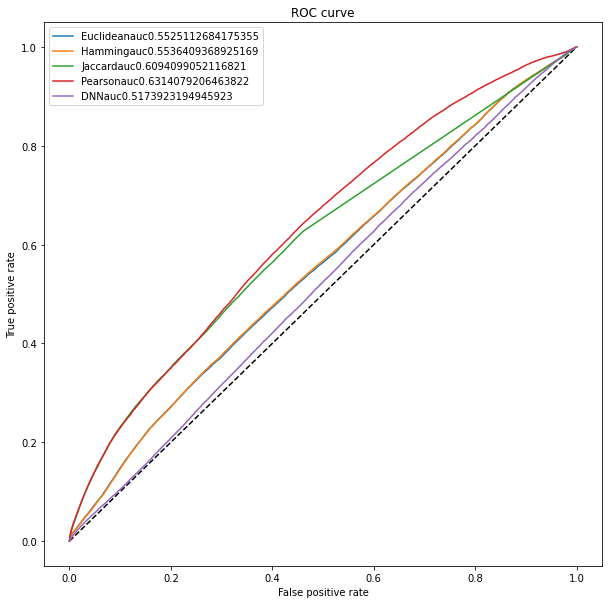

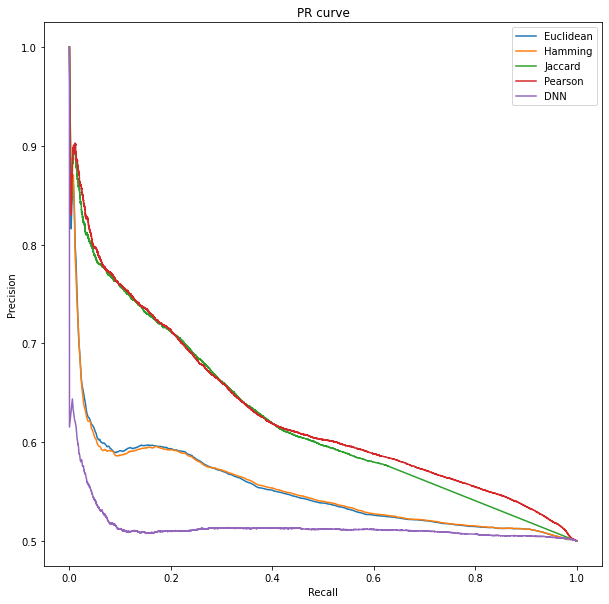

humap
Euclidean
Hamming
Jaccard
Pearson
DNN
{'Euclidean': {'Ypred': array([-15.5241747 , -37.17526059, -30.8058436 , ..., -22.69361144,
       -16.82260384, -13.49073756]), 'Ytrue': array([0, 0, 0, ..., 0, 1, 1])}, 'Hamming': {'Ypred': array([-0.01947929, -0.09977195, -0.03601292, ..., -0.04922083,
       -0.0290764 , -0.        ]), 'Ytrue': array([0, 0, 0, ..., 0, 1, 1])}, 'Jaccard': {'Ypred': array([-0.74957155, -0.37731849, -0.7425686 , ..., -0.81891496,
       -0.52772809, -0.44343675]), 'Ytrue': array([0, 0, 0, ..., 0, 1, 1])}, 'Pearson': {'Ypred': array([0.38187675, 0.80028944, 0.55500112, ..., 0.4791039 , 0.84102759,
       0.42213021]), 'Ytrue': array([0, 0, 0, ..., 0, 1, 1])}, 'DNN': {'Ypred': array([[0.00337863],
       [0.11950114],
       [0.00116023],
       ...,
       [0.9736501 ],
       [0.85069454],
       [0.4219874 ]], dtype=float32), 'Ytrue': array([0, 0, 0, ..., 0, 1, 1])}}
Euclidean
Hamming
Jaccard
Pearson
DNN


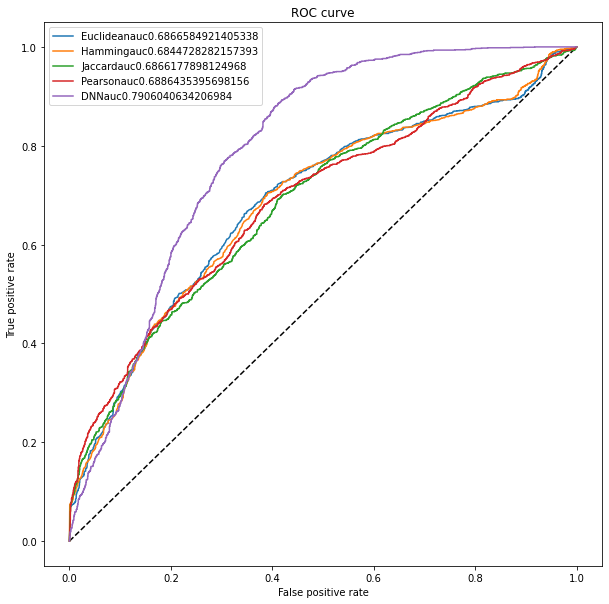

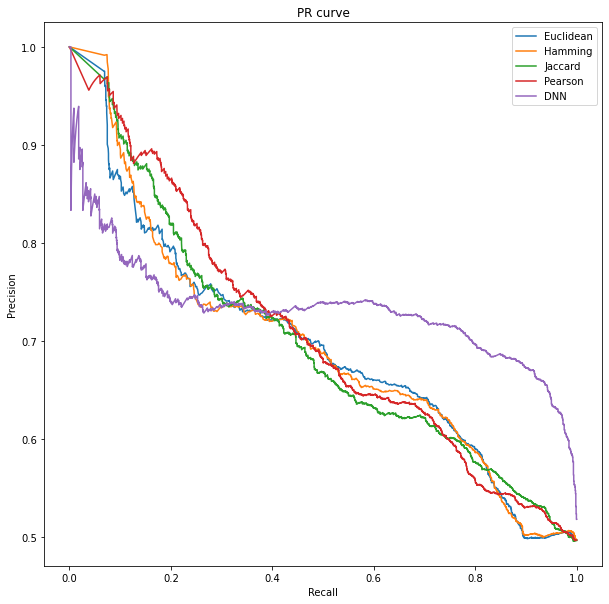

In [63]:
#normal distance metrics to try

from scipy.spatial.distance import euclidean , hamming, jaccard
from sklearn.covariance import empirical_covariance
from scipy.stats import pearsonr
from keract import get_activations
def pearsonR(v1,v2):
        return -pearsonr(v1,v2)[0]

for label in Datasets:
    print(label)
    df_test = Datasets[label]['Test']
    fam_map = Datasets[label]['mapping']
    profilemat = Datasets[label]['mat']
    ydata =  {}

    for func, name in [ (euclidean, 'Euclidean' ), (hamming,'Hamming') , (jaccard,'Jaccard') , (pearsonR,'Pearson') ]:
        print(name)
        generator = generateXYchunk(profilemat, df_test, fam_map , posi_percent= .5 , nsamples = 50 )
        #test all the easy metrics
        ypreds = []
        ytruth = []
        for X,y in generator:
            #distances
            x1 = X[:,0:int(X.shape[1]/2)]
            x2 = X[:,int(X.shape[1]/2):]
            predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
            ypreds.append(predictions)
            ytruth.append(y)
        ytest= np.hstack(ytruth)
        ypred = np.hstack(ypreds)
        ydata[name] = { 'Ypred': ypred , 'Ytrue':ytest} 
    #get DNN values
    print('DNN')
    generator = generateXYchunk(profilemat, df_test, fam_map , posi_percent= .5 , nsamples = 50 )
    mats = [(x,y) for x,y in generator ]
    y_test = np.hstack([y for x,y in mats])
    modelpath = './'+label+'_dropout_DNN.h5'
    if os.path.exists(modelpath):
        model = load_model(modelpath)
        
        
    ypred = np.vstack([ model.predict(x) for x,y in mats])
    
    
    #activations = [ get_activations(model, x , auto_compile=True) for x,y in mats] 
    #activations = activations[list(activations.keys())[0]]
    #print( activations.shape)
    #n_samples = activations.shape[0]
    #activations = np.sum(activations,axis =0)/n_samples
    #representations = np.sum(X_test, axis = 0)
    
    #print(activations.shape)
    
    #np.save(modelpath + 'activation.np' , activations)
    #np.save(modelpath + 'representation.np', representations)
    
    ydata['DNN'] ={ 'Ypred': ypred , 'Ytrue':ytest}
    #plot ROC
    print(ydata)
    ROC_curve(ydata , label = label)
    plt.show()


In [64]:
#######################being the graph NN part of the paper #####################################

In [65]:
import dendropy
taxnwk = '/scratch/dmoi/datasets/birds/all_test_master_tree.nwk'

with open( 'taxtree.nwk' , 'w') as treeout:
    treeout.write(p.tree.write())
dendrotree = dendropy.Tree.get(
        data=p.tree.write(),
        schema='newick')


In [212]:
import ete3
taxonomy = p.tree
taxmap ={ n.name :i for i,n in enumerate(taxonomy.traverse())}
reverse_taxmap = dict(zip(taxmap.values(), taxmap.keys()))
#im going to implement the graph net with dendropy
#we need to map the profile vectors from ete3 traversal to dendropy
tax = [n.taxon.label for n in dendrotree.nodes() if n.taxon ]
dendropy2ete3_index = np.array([ taxmap[n]  if str(n) in taxmap else taxmap['-1']  for n in tax ])



print(len(dendropy2ete3_index))
print(len(p.tree))

2429
2429


In [88]:
#setup the internal nodes for the fitch algo
for i,l in enumerate(dendrotree.nodes()):
    l.event = {}
    l.scores = {}
    l.symbols = None
    l.char= None
    l.matrow = i

In [89]:
print(Datasets['string'].keys())

dict_keys(['Train', 'Test', 'mapping', 'mat'])


In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
import smallpars
#we're checking for interaction in a subset of species and propagating up
allowed_symbols =set([0,1])
transition_dict = { (c[0],c[1]):i for i,c in enumerate(itertools.permutations(allowed_symbols,2) ) }

def calc_interaction_on_taxonomy(cog1,cog2,tree, bloom , verbose = False):
    #set interaction states
    #look for interactions in bloom
    for i,l in enumerate(tree.leaf_nodes()):
        l.event = {}
        l.scores = {}
        l.symbols = {}
        l.scores = { c:10**10 for c in allowed_symbols }
        if cog1+'_'+cog2+'_'+l.taxon.label in bloom:
            if verbose == True:
                print(l.taxon.label)
            l.char= 1
            l.symbols = {1}
        else:
            l.char= 0
            l.symbols = {0}
        l.scores[l.char] = 0
    t = smallpars.calculate_small_parsimony(tree ,allowed_symbols, transition_dict)
    return  t

In [214]:
def tree2Single_sparse_graph(tree):
    N = len(tree.nodes())
    index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    #features that apply to every node
    lengths = np.array([ c.edge_length for n in tree.nodes() for c in n.child_nodes()])
    lengths /= np.amax(lengths)
    ntime = np.array([ n.distance_from_root() for n in tree.nodes()])
    mtime = np.amax(ntime)
    ntime/=mtime
    levels = np.array([ n.level() for n in tree.nodes() ] , dtype='float')
    levels /= np.amax(levels)
    #totalnodes = len(tree.nodes())
    #Norm_ndescendant = np.array([ n./totalnodes for n in tree.nodes() ])
    Norm_nchild= np.array( [ len(n.child_nodes()) for n in tree.nodes() ] ,dtype='float' )
    mchild =np.amax(Norm_nchild)
    Norm_nchild/=mchild 
    template_features = np.stack([ntime ,  Norm_nchild  ]).T
    connectmat = scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat[index[:,0],index[:,1]] = 1
    diag = np.array([ i for i in range(connectmat.shape[0]) ] )
    connectmat = scipy.sparse.find(connectmat)
    print(connectmat)
    connectmat = np.hstack([connectmat[0],connectmat[1]])
    #get adjacency and node IDs
    return connectmat, template_features

In [215]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData


def create_data( tree, coglinkdf, bloom, profilemat ,  fam_map , taxindex , posi_percent= .5 , loop= True):
        #select lines from coglinks
        connectmat, template_features = tree2Single_sparse_graph(tree)
        num_total_nodes = template_features.shape[0]
        lineiterator = coglinkdf.iterrows()
        if loop == True:
            lineiterator = itertools.cycle(lineiterator)
        allfams = list(set(coglinkdf.fam1.unique()).union( set(coglinkdf.fam2.unique() ) ))
        #for each pair in the dataset / non-coev pair
        #coin toss to decide whether the sample is positive or negative
        while True:
            #toss = scipy.stats.bernoulli.rvs(posi_percent, loc=0, size=1, random_state=None)
            toss = 1
            if toss == 0:
                fam1 = random.choice(allfams)
                fam2 = fam1
                #make sure they arent the same
                while fam1 ==fam2:
                    fam2 = random.choice(allfams)
                #profile features
                labels = np.zeros((template_features.shape[0],))
            else:
                #positive sample
                idx,dfline = next(lineiterator)
                cog1= str(dfline.group1).replace("b",'').replace("'",'').strip()
                cog2= str(dfline.group2).replace("b",'').replace("'",'').strip()
                fam1 = dfline.fam1
                fam2 = dfline.fam2
                #get the features from fitch and profile
                t = calc_interaction_on_taxonomy(cog1,cog2,tree, bloom)
                labels = [ n.char for n in t.nodes() ]
            profile1 = profilemat[fam_map[fam1]]
            profile2 = profilemat[fam_map[fam2]]
            nodefeatures = np.zeros((template_features.shape[0],2) )
            print(taxindex, taxindex.shape)
            nodefeatures[taxindex,0] = profile1
            nodefeatures[taxindex,1] = profile2
            print(template_features)
            print(nodefeatures)
            
            nodefeatures = np.hstack([nodefeatures,template_features])    
            

            #data = HeteroData()
            #data['godnode', 'lords_over', 'phyloleaves'].edge_index = edge_index_author_paper
            
            
            data = Data(x = nodefeatures , edge_index= connectmat , y = labels )
            
            yield data

Traindata = create_data(dendrotree, Datasets['string']['Train'] ,cogfilter , Datasets['string']['mat'] ,  Datasets['string']['mapping'] , dendropy2ete3_index, posi_percent= .5  )
loader = DataLoader(Traindata, batch_size=32)


In [ ]:
 print(next(Traindata))

In [ ]:
#using a small graph toy network

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [86]:
print(GCN)

<class '__main__.GCN'>


In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

AttributeError: 'str' object has no attribute 'num_node_features'

In [ ]:
model.train()
for epoch in range(200):
    data = dataset[0].to(device)
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [ ]:

model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')


In [81]:
data_list = [Data(...), ..., Data(...)]
loader = DataLoader(data_list, batch_size=32)

In [ ]:
#bonus graph neural networks"!

#encode phylogenies as graphs

#make sandwhich layer


#train graph nn receptive field


#predict on human node

#predict on several nodes
#use string data and get all interaction interlogs

#propagate the feature of interaction using fitch in sandwhich layer

#compare AUC in different branches

